In [1]:
from rlxml import rlxstats as rs
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import minimize
import pandas as pd
from progressbar import progressbar as pbar
%matplotlib inline
from local.lib.v2 import histos2d as h2

$$L(\mu) = \prod\frac{(\mu s_i + b_i)^{n_i}}{n_i!}e^{-(\mu s_i + b_i)}$$

$$\sum n_i \log(\mu s_i + b_i) - \log(n_i!) - (\mu s_i + b_i)$$

In [2]:
# log of factorial, vectorized
log_fact = np.vectorize(lambda x: np.sum(np.log(range(1,x+1))))

class SignalBg:
    def __init__(self, f_sg, f_bg, mu, xmin=0, xmax=1000, btot=2000, stot=2000, nbins=10):
        """
        mu: strength parameter
        stot, btot: number of signal and background events (eqs 2,3,4)
        """
        assert mu>=0, "mu must be >=0"
        
        self.f_sg, self.f_bg = f_sg, f_bg
        self.Z_sg = quad(f_sg, xmin, xmax)[0]
        self.Z_bg = quad(f_bg, xmin, xmax)[0]
        
        self.stot, self.btot, self.mu = stot, btot, mu
        self.xmin, self.xmax = xmin, xmax
        self.nbins = nbins
        self.bins = np.concatenate([np.linspace(xmin, xmax,nbins), [np.inf]])
        
        # compute normalized pdfs for bg and sg
        self.pdf_sg = lambda x: self.f_sg(x)/self.Z_sg
        self.pdf_bg = lambda x: self.f_bg(x)/self.Z_bg
        
        # compute normalize pdf
        self.build_pdf()
        
        # compute si and bi according to eqs 3,4
        self.si, self.bi = [], []
        for i in range(len(self.bins)-1):    
            self.si.append(self.stot * quad(self.pdf_sg, self.bins[i], self.bins[i+1])[0])
            self.bi.append(self.btot * quad(self.pdf_bg, self.bins[i], self.bins[i+1])[0])                    
        self.si = np.r_[self.si]
        self.bi = np.r_[self.bi]

        # poisson distribution for bins (if we want to use them for likelihood_bins)
        self.poissons = [stats.poisson(mu=self.mu*self.si[i]+self.bi[i]) for i in range(self.nbins)]

    def loglikhood_binned(self, ni):
        ni = ni.copy()
        ni[ni==0]=1
        # computing manually poisson pdf
        return np.sum(ni*np.log(self.mu*self.si+self.bi)-log_fact(ni)-(self.mu*self.si+self.bi))        
        # using poisson pdf from scipy.stats
        #return np.sum([np.log(self.poissons[i].pmf(ni[i])) for i in range(self.nbins)])
    
    def loglikhood(self, x):
        return np.sum(np.log(self.pdf(x)))    
    
    def set_mu(self, mu):
        self.mu = mu
        self.build_pdf()
        return self
    
    def build_pdf(self):
        def pdf(x):
            r = self.pdf_bg(x) + self.mu * self.pdf_sg(x)
            if type(r)==np.ndarray:
                r[r<0]=0
            else:
                r = 0 if r<0 else r
            return r
        self.Z = quad(pdf, self.xmin, self.xmax)[0]
        self.Z = 1 if self.Z==0 else self.Z
        self.pdf = lambda x: pdf(x)/self.Z            
            
    def rvs(self):
        """
        samples one experiment
        """
        b = rs.sample_unnormalized_pdf_1d(self.f_bg, self.xmin, self.xmax, n_samples=self.btot)
        s = rs.sample_unnormalized_pdf_1d(self.f_sg, self.xmin, self.xmax, n_samples=int(self.stot*self.mu))
        return np.random.permutation(np.concatenate([b,s]))
    
    def binarize(self, x):
        """
        binarizes one experiments, x must contain events, such as returned by rvs
        """
        return np.histogram(x, self.bins)[0]
        
    def sample_loglkhood(self, n):
        r = []
        for _ in range(1000):
            x = self.rvs()
            r.append([self.loglikhood(x), self.loglikhood_binned(self.binarize(x))])
        r = pd.DataFrame(r, columns=["loglikhood", "loglikhood_binned"])
        return r
    
    def mu_MLE(self, x):
        mu_backup = self.mu
        f = lambda mu: -self.set_mu(mu).loglikhood(x)
        r = minimize(f, 1, method="SLSQP", bounds=[(0,None)]).x[0]
        #r = minimize(f, 1, method="BFGS").x[0]#, bounds=[(0,None)]).x[0]
        self.set_mu(mu_backup)
        return r

    def mu_MLE_binned(self, xb):
        mu_backup = self.mu
        f = lambda mu: -self.set_mu(mu).loglikhood_binned(xb)
        r = minimize(f, 1, method="SLSQP", bounds=[(0,None)]).x[0]
        #r = minimize(f, 1, method="BFGS").x[0] #, bounds=[(0,None)]).x[0]
        self.set_mu(mu_backup)
        return r

    def t_mu(self, mu, x):
        mu_backup = self.mu
        L_mu = self.set_mu(mu).loglikhood(x)
        L_mu_hat = self.set_mu(self.mu_MLE(x)).loglikhood(x)
        t = -2*(L_mu-L_mu_hat)
        self.set_mu(mu_backup)
        return t

    def t_mu_binned(self, mu, xb):
        mu_backup = self.mu
        L_mu = self.set_mu(mu).loglikhood_binned(xb)
        L_mu_hat = self.set_mu(self.mu_MLE_binned(xb)).loglikhood_binned(xb)
        t = -2*(L_mu-L_mu_hat)
        self.set_mu(mu_backup)
        return t    
    
    def q_mu(self, mu, x):
        mu_backup = self.mu
        L_mu = self.set_mu(mu).loglikhood(x)
        mu_MLE = self.mu_MLE(x)
        L_mu_hat = self.set_mu(mu_MLE).loglikhood(x)
        t = -2*(L_mu-L_mu_hat) if mu_MLE<mu else 0
        self.set_mu(mu_backup)
        return t

    def q_mu_binned(self, mu, xb):
        mu_backup = self.mu
        L_mu = self.set_mu(mu).loglikhood_binned(xb)
        mu_MLE = self.mu_MLE_binned(xb)
        L_mu_hat = self.set_mu(mu_MLE).loglikhood_binned(xb)
        t = -2*(L_mu-L_mu_hat) if mu_MLE<mu else 0
        self.set_mu(mu_backup)
        return t    
    
    def get_sampling_distributions(self, n=1000):
        r = []
        for _ in pbar(range(n)):
            x = self.rvs()
            xb = self.binarize(x)

            r.append([self.t_mu(self.mu, x), self.t_mu_binned(self.mu, xb), 
                      self.q_mu(self.mu, x), self.q_mu_binned(self.mu, xb),
                      self.mu_MLE(x), self.mu_MLE_binned(xb)])

        r = pd.DataFrame(r, columns=["tmu_cont", "tmu_binned", "qmu_cont", "qmu_binned", "hmu_cont", "hmu_binned"])
        return r
    
    def plot_binarized(self, h):
        """
        h: vector with counts of events on each bin, such as returned by binarize
        """
        plt.bar(self.bins[:-1], h, (self.bins[1]-self.bins[0])*.8)        
        plt.plot(self.bins[:-1])
        plt.ylabel("number of events")
        plt.grid();

    def plot_binarized(self, h, plot_bins_borders=False, **kwargs):
        """
        h: vector with counts of events on each bin, such as returned by binarize
        """
        bins = self.bins.copy()
        bsize = bins[1] - bins[0]
        bins[-1] = bins[-2] + bsize
        plt.bar(bins[:-1]+bsize/2, h, bsize*.8, label="binarized sample", **kwargs)        
        plt.ylabel("number of events")
        plt.grid();
        if plot_bins_borders:
            for i in self.bins[1:-1]:
                plt.axvline(i, color="red", alpha=1, ls="--")
        plt.plot(bins[:-1]+bsize/2, self.mu*self.si+self.bi, label="expected", color="black")
        plt.legend();
        
        
    def plot_funcs(self):
        xr = np.linspace(xmin, xmax, 100)
        plt.plot(xr, self.pdf_bg(xr), color="black", ls="--", 
                 label="$pdf_b$: background")
        plt.plot(xr, (lambda x: self.mu*self.pdf_sg(x))(xr), color="black", 
                 label=r"$\mu \times pdf_s$: signal")
        plt.plot(xr, self.pdf_bg(xr)+self.mu*self.pdf_sg(xr), color="red", 
                 label=r"$pdf = pdf_s + \mu \times pdf_b$ (unnormalized)")
        plt.grid();
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        
    def plot_pdf(self, **kwargs):
        xr = np.linspace(self.xmin, self.xmax, 100)
        plt.plot(xr, self.pdf(xr), **kwargs)
        plt.ylabel("probability")
        plt.grid();

In [3]:
fbg = lambda x: 100*np.exp(-0.01*x)
fsg = lambda x: np.exp(-(x-650)**2/200)

sg = SignalBg(fsg,fbg,mu=0., stot=5000, btot=10000, nbins=21)

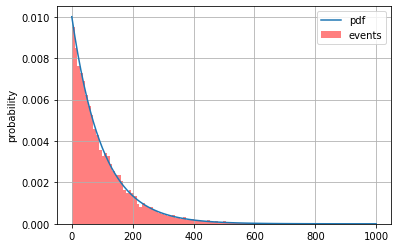

In [4]:
x = sg.rvs()
sg.plot_pdf(label="pdf")
plt.hist(x, density=True, color="red", alpha=.5, bins=100, label="events");
plt.legend();

In [5]:
h = sg.binarize(x)
h

array([3883, 2354, 1489,  917,  511,  326,  195,  119,   81,   51,   35,
         14,   11,    4,    5,    1,    2,    2,    0,    0,    0])

In [6]:
sg.bins

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000.,   inf])

In [10]:
sg.bi

array([3.93487205e+03, 2.38662054e+03, 1.44755853e+03, 8.77988630e+02,
       5.32527023e+02, 3.22993966e+02, 1.95905744e+02, 1.18822840e+02,
       7.20696955e+01, 4.37124799e+01, 2.65129593e+01, 1.60809227e+01,
       9.75357265e+00, 5.91584085e+00, 3.58813886e+00, 2.17631623e+00,
       1.32000252e+00, 8.00621997e-01, 4.85601788e-01, 2.94532373e-01,
       4.54020611e-01])

In [50]:
h = np.r_[[3942.0, 2352.0, 1449.0, 911.0, 531.0, 299.0, 199.0, 
           128.0, 51.0, 53.0, 25.0, 22.0, 17.0, 5.0, 11.0, 2.0, 2.0, 0.0, 1.0, 0., 0.]].astype(int)
h

array([3942, 2352, 1449,  911,  531,  299,  199,  128,   51,   53,   25,
         22,   17,    5,   11,    2,    2,    0,    1,    0,    0])

In [46]:
sg.loglikhood_binned(h)

-1596.6408710588792

In [47]:
logfact = lambda x: np.sum([np.log(i) for i in range(x,0,-1)])

In [49]:
sg.loglikhood_binned(h) - np.sum([logfact(i) for i in h])

-30661.373424740195

In [52]:
sg.mu_MLE_binned(h)

0.0009602359242610594

In [42]:
sg.loglikhood_binned(h) - np.sum([logfact(i) for i in h])

-65117.01201812633

In [24]:
sg.mu_MLE_binned(h)

0.0009602359242610594

In [27]:
logfact = lambda x: np.sum([np.log(i) for i in range(x,0,-1)])

In [30]:
import math
np.log(math.factorial(12))

19.987214495661885

In [15]:
binned_samples = np.r_[[sg.binarize(sg.rvs()) for _ in range(1000)]]

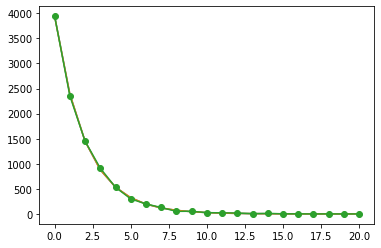

In [20]:
plt.plot(binned_samples.mean(axis=0))
plt.plot(sg.bi)
plt.plot(h, marker="o")

## setup a experiment

In [239]:
fbg = lambda x: 100*np.exp(-0.005*x)
fsg = lambda x: np.exp(-(x-650)**2/2600)

sg = SignalBg(fsg,fbg,mu=.2, stot=5000, btot=5000, nbins=30)

## sample events

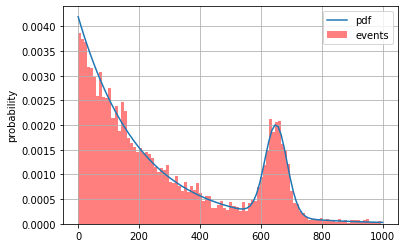

In [240]:
x = sg.rvs()
sg.plot_pdf(label="pdf")
plt.hist(x, density=True, color="red", alpha=.5, bins=100, label="events");
plt.legend();

## binarized sampled events

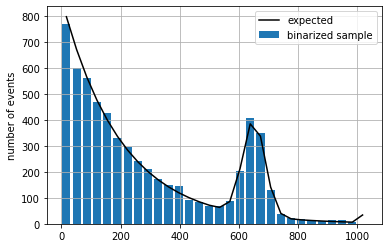

In [241]:
xb = sg.binarize(x)
sg.plot_binarized(xb)

## likelihoods are very different

In [242]:
sg.loglikhood(x), sg.loglikhood_binned(xb)

(-38649.307981845224, -138.7148338981239)

## and not related!!!!

In [243]:
k = sg.sample_loglkhood(500)

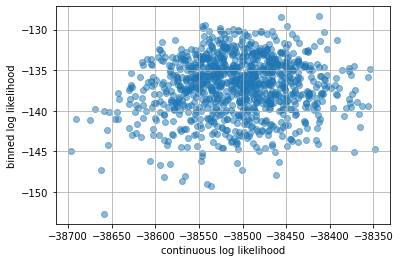

In [244]:
plt.scatter(k.loglikhood, k.loglikhood_binned, alpha=.5)
plt.xlabel("continuous log likelihood")
plt.ylabel("binned log likelihood")
plt.grid();

## unbinned likelihood seems to distinguish better different values for $\mu$

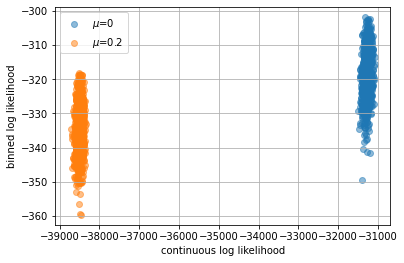

In [245]:
k0 = SignalBg(fsg,fbg,mu=.0, stot=5000, btot=5000, nbins=100).sample_loglkhood(500)
k1 = SignalBg(fsg,fbg,mu=.2, stot=5000, btot=5000, nbins=100).sample_loglkhood(500)

plt.scatter(k0.loglikhood, k0.loglikhood_binned, alpha=.5, label="$\mu$=0")
plt.scatter(k1.loglikhood, k1.loglikhood_binned, alpha=.5, label="$\mu$=0.2")
plt.legend();
plt.xlabel("continuous log likelihood")
plt.ylabel("binned log likelihood")
plt.grid();


## however MLE for $\mu$ seem similar

In [246]:
sg = SignalBg(fsg,fbg,mu=0, stot=5000, btot=5000, nbins=30)
x = sg.rvs()
xb = sg.binarize(x)

In [247]:
rmu = np.linspace(0,1.2,20)
l_cont = [-sg.set_mu(mu).loglikhood(x) for mu in rmu]
l_bins = [-sg.set_mu(mu).loglikhood_binned(xb) for mu in rmu]

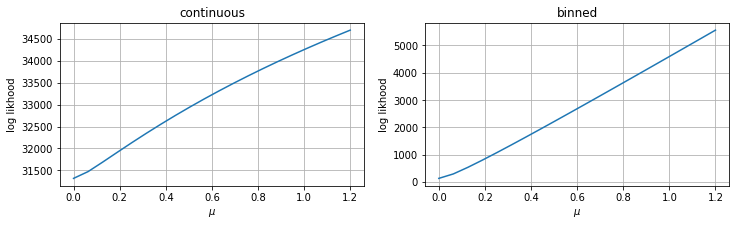

In [248]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(rmu, l_cont)
plt.grid(); plt.xlabel("$\mu$"); plt.ylabel("log likhood"); plt.title("continuous")
plt.subplot(122)
plt.plot(rmu, l_bins)
plt.grid(); plt.xlabel("$\mu$"); plt.ylabel("log likhood"); plt.title("binned");

In [251]:
mus = np.random.random(size=100)
r = []
for mu in pbar(mus):
    sg = SignalBg(fsg,fbg,mu=mu, stot=5000, btot=5000, nbins=30)
    for _ in range(10):
        x = sg.rvs()
        xb = sg.binarize(x)
        r.append([mu, sg.mu_MLE(x), sg.mu_MLE_binned(xb)])
km = pd.DataFrame(r, columns=["mu", "hmu_cont", "hmu_binned"])


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


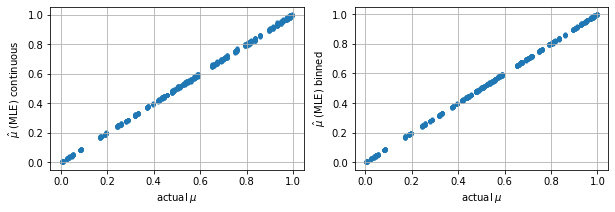

In [252]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.scatter(km.mu, km.hmu_cont, s=10)
plt.xlabel("actual $\mu$")
plt.ylabel("$\hat{\mu}$ (MLE) continuous")
plt.grid();
plt.subplot(122)
plt.scatter(km.mu, km.hmu_binned, s=10)
plt.xlabel("actual $\mu$")
plt.ylabel("$\hat{\mu}$ (MLE) binned")
plt.grid();

## the sampling distributions of the likelihood

In [253]:
k = sg.sample_loglkhood(4000)

Text(0.5, 1.0, 'binned')

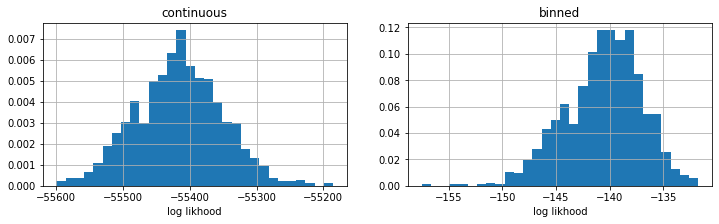

In [254]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.hist(k.loglikhood.values, density=True, bins=30);
plt.grid(); plt.xlabel("log likhood"); plt.title("continuous")
plt.subplot(122)
plt.hist(k.loglikhood_binned.values, density=True, bins=30);
plt.grid(); plt.xlabel("log likhood"); plt.title("binned")

## $\hat{\mu}$: the MLE for $\mu$

In [255]:
sg = SignalBg(fsg,fbg,mu=0., stot=5000, btot=5000, nbins=30)
x = sg.rvs()
xb = sg.binarize(x)

In [256]:
sg.mu_MLE(x)

0.002545805959378097

In [257]:
%timeit sg.mu_MLE(x)

20.1 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [258]:
sg.mu_MLE_binned(xb)

0.003129905331524276

In [259]:
%timeit sg.mu_MLE_binned(xb)

33.1 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## test statistic $t_\mu = -2 (\mathcal{L}(\mu|x) - \mathcal{L}(\hat{\mu}|x))$ 

In [260]:
sg.t_mu(0, x)

1.1901530358591117

In [261]:
sg.t_mu_binned(0, xb)

1.81679716257554

## sampling distribution of $\hat\mu$ for a fixed real $\mu'$

In [269]:
sg = SignalBg(fsg,fbg,mu=0., stot=5000, btot=5000, nbins=30)
km = sg.get_sampling_distributions(n=500)

100% (500 of 500) |######################| Elapsed Time: 0:00:45 Time:  0:00:45


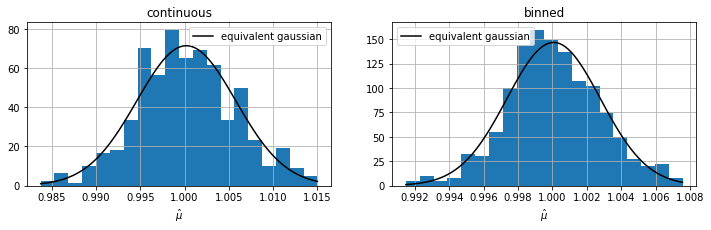

In [263]:
plt.figure(figsize=(12,3))
plt.subplot(121)
v = km.hmu_cont.values
h2.distplot(v, bins=20, pdf=stats.norm(loc=np.mean(v), scale=np.std(v)).pdf, pdf_name="equivalent gaussian")
plt.xlabel("$\hat{\mu}$"); plt.title("continuous")
plt.subplot(122)
v = km.hmu_binned.values
h2.distplot(v, bins=20, pdf=stats.norm(loc=np.mean(v), scale=np.std(v)).pdf, pdf_name="equivalent gaussian")
plt.xlabel("$\hat{\mu}$"); plt.title("binned");


### $\hat{\mu}$ are quite correlated in continuous and binned models

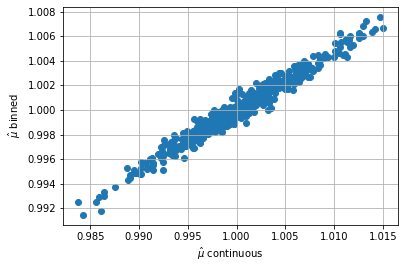

In [264]:
plt.scatter(km.hmu_cont, km.hmu_binned)
plt.xlabel("$\hat{\mu}$ continuous")
plt.ylabel("$\hat{\mu}$ binned")
plt.grid();


## sampling distribution of $t_\mu: f(t_\mu|\mu)$

(0.0, 10.0)

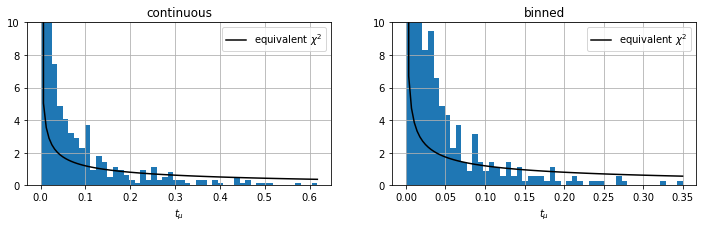

In [265]:
plt.figure(figsize=(12,3))
plt.subplot(121)
v = km.tmu_cont.values
h2.distplot(v, bins=50, pdf=stats.chi2(df=1).pdf, pdf_name="equivalent $\chi^2$")
plt.xlabel("$t_\mu$"); plt.title("continuous")
plt.ylim(0,10)

plt.subplot(122)
v = km.tmu_binned.values
h2.distplot(v, bins=50, pdf=stats.chi2(df=1).pdf, pdf_name="equivalent $\chi^2$")
plt.xlabel("$t_\mu$"); plt.title("binned")
plt.ylim(0,10)

(0.0, 10.0)

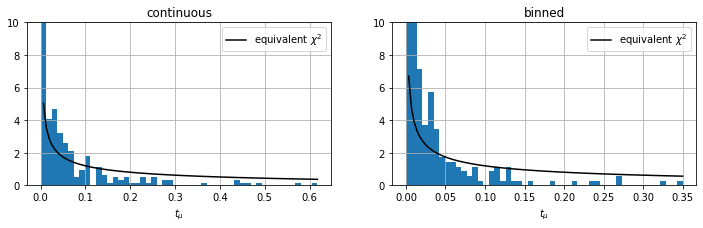

In [266]:
plt.figure(figsize=(12,3))
plt.subplot(121)
v = km.qmu_cont.values
h2.distplot(v, bins=50, pdf=stats.chi2(df=1).pdf, pdf_name="equivalent $\chi^2$")
plt.xlabel("$t_\mu$"); plt.title("continuous")
plt.ylim(0,10)
plt.subplot(122)
v = km.qmu_binned.values
h2.distplot(v, bins=50, pdf=stats.chi2(df=1).pdf, pdf_name="equivalent $\chi^2$")
plt.xlabel("$t_\mu$"); plt.title("binned")
plt.ylim(0,10)


### and, $t_\mu$ seems correlated in continuous and binned modes

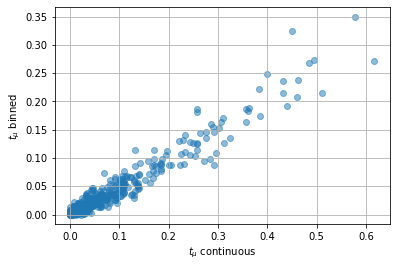

In [267]:
plt.scatter(km.tmu_cont, km.tmu_binned, alpha=.5)
plt.xlabel("$t_{\mu}$ continuous")
plt.ylabel("$t_{\mu}$ binned")
plt.grid();
#plt.xlim(0,1)
#plt.ylim(0,.1)

### checking Wald approximation 

$$t_\mu = \frac{(\mu-\hat{\mu})^2}{\sigma^2} + \mathcal{O}(1/\sqrt{N})$$

(0.0, 1.5)

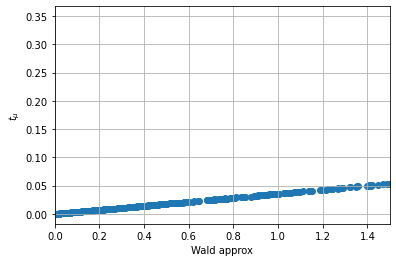

In [268]:
hmu_sigma = km.hmu_binned.std()

wald = (sg.mu-km.hmu_binned.values)**2/hmu_sigma**2
plt.scatter(wald, km.tmu_binned)
plt.ylabel("$t_\mu$"); plt.xlabel("Wald approx")
plt.grid();
plt.xlim(0,1.5)

## distribution of $\hat{\mu}$ for different real $\mu$

In [38]:
mus = np.random.random(size=100)
r = []
for mu in pbar(mus):
    sg = SignalBg(fsg,fbg,mu=mu, stot=5000, btot=5000, nbins=30)
    for _ in range(10):
        x = sg.rvs()
        xb = sg.binarize(x)
        r.append([mu, sg.mu_MLE(x), sg.mu_MLE_binned(xb)])
kmm = pd.DataFrame(r, columns=["mu", "hmu_cont", "hmu_binned"])


100% (100 of 100) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


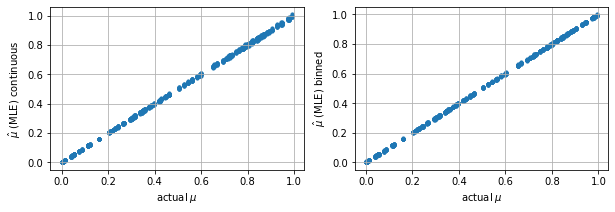

In [39]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.scatter(kmm.mu, kmm.hmu_cont, s=10)
plt.xlabel("actual $\mu$")
plt.ylabel("$\hat{\mu}$ (MLE) continuous")
plt.grid();
plt.subplot(122)
plt.scatter(kmm.mu, kmm.hmu_binned, s=10)
plt.xlabel("actual $\mu$")
plt.ylabel("$\hat{\mu}$ (MLE) binned")
plt.grid();

In [92]:
 km.hmu_binned.std(),  km.hmu_cont.std()

(0.0025953795984393594, 0.003191141986177014)

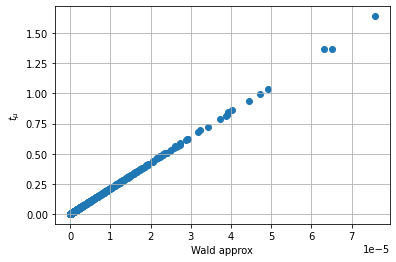

In [86]:
wald = (sg.mu-km.hmu_binned.values)**2
plt.scatter(wald, km.tmu_binned)
plt.ylabel("$t_\mu$"); plt.xlabel("Wald approx")
plt.grid();


In [82]:
hmu_sigma

0.0025953795984393594